In [4]:
import numpy as np
import pandas as pd
import torch
import pyro
import tyxe
from torch import nn
from torch.utils.data import Dataset, DataLoader
import functools
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pyro.distributions as dist
from pyro.infer import SVI
import os
import network

In [2]:
# set matplotlib settings
#%matplotlib inline
#plt.style.use('ggplot')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cpu


In [6]:
data = pd.read_csv("data/sign_mnist_train.csv")
tdata = pd.read_csv("data/sign_mnist_test.csv")

In [7]:
dataset_size = len(data["label"])
print(dataset_size)
n_classes = data["label"].nunique()
print(n_classes)

27455
24


In [8]:
y_train = data["label"]
X_train = data.drop(columns =["label"])

y_test = tdata["label"]
X_test = tdata.drop(columns =["label"])

In [9]:
class SignLanguageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label

In [10]:
y_train[y_train > 8] = y_train[y_train > 8] - 1
pf = y_train[y_train == 9]

In [11]:
y_test[y_test > 8] = y_test[y_test > 8] - 1

In [12]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), 
    transforms.Normalize(110, 110), 
    # transforms.ToTensor(), 
    # transforms.Normalize(159, 40), 
])   

test_transforms = transforms.Compose([
    transforms.Normalize(110, 110)
])

train_data = SignLanguageDataset(data, transform=train_transforms)
test_data = SignLanguageDataset(tdata, transform=test_transforms)

In [13]:
# dataloaders
trainloader = DataLoader(
    train_data, 
    batch_size=100, 
    #pin_memory=use_cuda, 
    #num_workers=2 * int(use_cuda), 
    shuffle=True
    )

testloader = DataLoader(
    test_data, 
    batch_size=100, 
    shuffle=True
    )

In [15]:
net = network.network(in_channels=1, output_size=24, device=device)

In [16]:
prior_kwargs = dict() # expose_all=False, hide_module_types=(nn.BatchNorm2d,))

likelihood = tyxe.likelihoods.Categorical(len(trainloader.sampler))

prior = tyxe.priors.IIDPrior(
    dist.Normal(torch.zeros(1, device=device), torch.ones(1, device=device)), 
    **prior_kwargs
    )
                                 
guide = functools.partial(
    tyxe.guides.AutoNormal, 
    init_loc_fn=tyxe.guides.PretrainedInitializer.from_net(net, prefix="net"), 
    init_scale=1e-4, 
    max_guide_scale=1
    ) #, train_loc=not scale_only)
    
bnn = tyxe.VariationalBNN(net, prior, likelihood, guide)

In [17]:
pyro.clear_param_store()

lr = 1e-3
n_epochs = 10
optim = pyro.optim.Adam({"lr": lr})

error = []

def callback(b, i, avg_elbo):
    avg_err, avg_ll = 0., 0.
    b.eval()
    for x, y in iter(testloader):
        err, ll = b.evaluate(x.to(device), y.to(device), num_predictions=10)
        avg_err += err / len(testloader.sampler)
        avg_ll += ll / len(testloader.sampler)
    error.append(avg_err)
    print(end = f"  ELBO={avg_elbo}; test error={100 * avg_err:.2f}%; LL={avg_ll:.4f}")
    b.train()

In [18]:
#with tyxe.poutine.local_reparameterization():
bnn.fit(trainloader, optim, n_epochs, callback, device=device)

  ELBO=30713610.414545454; test error=9.98%; LL=-0.3925

In [19]:
error_cpu = [error[i].to("cpu")*100 for i in range(len(error))]

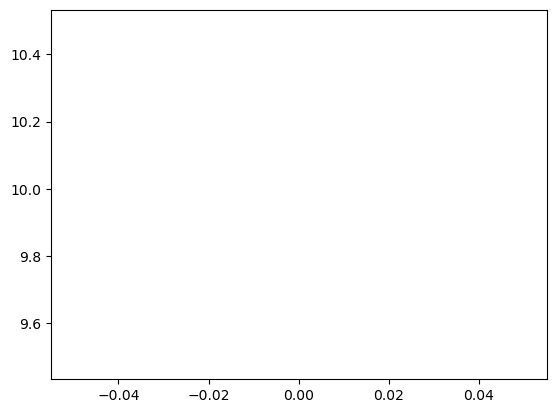

In [20]:
_=plt.plot(error_cpu)

In [22]:
test_predictions = torch.cat([bnn.predict(x.to(device), num_predictions=1) for x, _ in iter(testloader)])

In [23]:
print(test_predictions[60])

tensor([ -9.7060, -15.9424, -15.9424, -13.8930,  -0.0449, -12.0400, -15.9424,
        -15.9424, -11.6877, -15.9424, -15.9424,  -5.8047, -12.8983, -14.0175,
        -15.9424, -10.4211, -15.9424,  -3.1995, -15.9424, -15.9424, -15.9424,
        -15.9424, -15.9424, -15.9424])


Text(0.5, 1.0, 'Prediction likelihood')

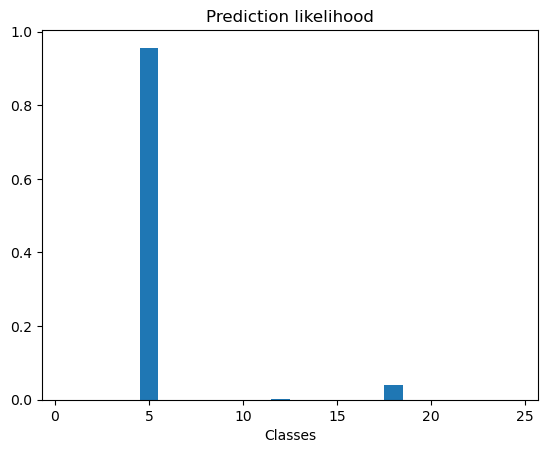

In [24]:
t = np.array([test_predictions[60][i].to("cpu") for i in range(len(test_predictions[0]))])
#hist = torch.histc(t, bins = 2, min = 0, max = 1)

bins = 24
x = range(1,25,1)

#plt.bar(x, hist, align='center')
plt.bar(x, np.exp(t), width=1, align='center')

plt.xlabel('Classes')
plt.title('Prediction likelihood')

### Save Pre-Trained bcnn

In [25]:
# Save
'''
output_dir = 'output/bcnn'
if output_dir is not None:
    pyro.get_param_store().save(os.path.join(output_dir, "param_store.pt"))
    torch.save(bnn.net.state_dict(), os.path.join(output_dir, "state_dict.pt"))
'''

'\noutput_dir = \'output/bcnn\'\nif output_dir is not None:\n    pyro.get_param_store().save(os.path.join(output_dir, "param_store.pt"))\n    torch.save(bnn.net.state_dict(), os.path.join(output_dir, "state_dict.pt"))\n'